# Predicting House Sale Prices

The Ames Housing dataset has been collected by professor [Dean De Cock](https://www.truman.edu/faculty-staff/decock/) as an alternative to the Boston Housing dataset for [teaching purposes](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), with special regard to regression. <br>
The dataset is a collection of data about sales of houses in Ames, Iowa, between 2006 and 2010.<br>
The documentation about the data can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt)


In this project, I'll use the dataset to train a linear regression model with scikit-learn LinearRegression class and predict house prices.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [79]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [80]:
data = pd.read_csv("AmesHousing.tsv", delimiter="\t")

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [82]:
def train_and_test(df, train_feature):
    df = data.sample(frac=1, random_state = 1)
    train = df.iloc[0:1460].copy()
    test = df.iloc[1460:].copy()
    train_feat = train[[train_feature]]
    train_feat.dropna(inplace=True)
    target = train["SalePrice"][train_feat.index]
    lr = LinearRegression()
    lr.fit(train_feat, target)
    test_feat = test[[train_feature]]
    test_feat.dropna(inplace=True)
    test_target = test["SalePrice"][test_feat.index]
    prediction = lr.predict(test_feat)
    mse = mean_squared_error(test_target, prediction)
    rmse = np.sqrt(mse)
    return rmse
    

### Testing a Simple Linear Regression Model

I'll initially test some simple regression models, with just one feature. <br>
Below a list of the feature more correlatd to the target column, SalePrice.<br>
In this phase I won't scale the features because I'm using just one feature at the time, so scaling isn't useful.

In [83]:
sorted_corrs = data.corr()["SalePrice"].apply(abs).sort_values(ascending=False)
sorted_corrs

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID                0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch     0.128787
Kitchen AbvGr      0.119814
Screen Porch       0.112151
Overall Cond       0.101697
MS SubClass        0.085092
Pool Area          0.068403
Low Qual Fin SF    0.037660
Bsmt Half Bath     0.035835
Mo Sold            0.035259
3Ssn Porch         0.032225
Order              0

I'll now test some of the most correlated columns with a simple regression model, so one at the time, chossing between columsn with continuous values, the erros between predicted values and real values is expressed as RMSE.

In [84]:
selected_features = ["Gr Liv Area","Garage Area", "Total Bsmt SF", 
                     "1st Flr SF", "Mas Vnr Area"]

In [85]:
pd.options.mode.chained_assignment = None 
for feature in selected_features:
    rmse = train_and_test(data, feature)
    print("{0:15} {1:}".format(feature, rmse))

Gr Liv Area     55943.34407431997
Garage Area     60401.853379543405
Total Bsmt SF   60365.07126928037
1st Flr SF      61562.05969816064
Mas Vnr Area    67869.7635668466


The predicted value with a single column has a quite high rmse for all of the columns testesd, ranging from about 56,000 to about 68,000 dollars.

### Data Cleaning

Before splitting the dataset in train and test I'll remove the columns **Order** and **PID** because they aren't useful for predicting, then I'll convert the **MS Subclass** column from numeric to category because it represents codes for the kind of dwelling and not a numeric measure. <br>
For every category column, if one of the categories is represented by less than equal to 25 elements (0.8% of all the dataset), I'll convert it to category "other", this way I'll group togheter instances not very representative.
I'll then convert all the "object" columns to category.
I'll then remove columns represented for over 95% by just one type of the category, because they are again very little predictive.

In [86]:
data_copy = data.copy()

In [87]:
## I'll convert first this column to object in order to manipulate it and then it will be converted to category
data_copy['MS SubClass'] = data_copy.astype('object')

In [88]:
def remove_null_columns_with_threshold(df, threshold = 5):
    """
   Remove columns from a DataFrame with a number of
   null values over a threshold.
   The threshold is a percentage between 0 an 100 (extremes not included).
   Raise ValueError for invalid threshold values.

   Parameters
   df (DataFrame): the DataFrame to manipulate
   
   threshold (float): a value between 0 and 100 (extremes not included)
   
   Returns: the cleaned DataFrame
"""
    
    if threshold <= 0 | threshold >= 100:
        message = "threshold must be a number between (0,100), you entered {}".format(threshold)
        raise ValueError(message)
    # removing columns with too many null values, over threshold%
    null_values_in_cols = df.isnull().sum()
    threshold = int(df.shape[0] * (threshold/100))
    columns_to_mantain = null_values_in_cols[null_values_in_cols < threshold]
    data_1 = df[columns_to_mantain.index]
    return data_1
    

In [89]:
data_copy = remove_null_columns_with_threshold(data_copy, 5)

In [90]:
def analyze_and_transform_object_cols(data, threshold = 0.90):
    size = data.shape[0]
    df = data.select_dtypes(include=['object'])
    columns_obj = list(df.columns)
    columns_to_drop = []
    for col in columns_obj:
        v_counts = df[col].value_counts().sort_values(ascending = False)
        most_frequent = v_counts.iloc[0]
        if most_frequent/size >= threshold:
            columns_to_drop.append(col)
        else:
            for index, value in v_counts.iteritems():
                if value <= 25:
                    df[col][df[col] == index] = 'other'
    data = data.drop(columns_to_drop, axis= 1)              
    for col in df.columns:
        data[col] = df[col]
                    
    return data      

In [91]:
def convert_object_to_category(df):
    data_object_cols = df.select_dtypes(include=['object']).columns
    for col in data_object_cols:
        df[col] = df[col].astype('category')
        
    return df    

In [92]:
data_copy = analyze_and_transform_object_cols(data_copy, 0.95)

In [93]:
data_copy.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape',
       'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
    

In [94]:
data_copy = convert_object_to_category(data_copy)

In [95]:
data_copy = data_copy.sample(frac=1, random_state = 1).reset_index(drop=True)

In [96]:
train = data_copy.iloc[0: 1460].copy()
test = data_copy.iloc[1460: ].copy()

Below a series of functions I'll use to clean the train dataset, the same transformations will be applied to the test set. I'll remove columns with over 5% of null values, I'll impute missing values for both category and numerical columns and I'll add two new column: the column age, indicating the age of the house at the time of the sale and years_until_remod, indicating the number of years from the last renovation of the house. <br>

In [97]:
def impute_numeric_columns_with_mean(df):
    """
   Impute numeric columns included in numpy.number with the mean of the columns
   
   Parameters:
   
   df (DataFrame): the DataFrame to impute
   
   Returns:
   the imputed DataFrame
"""
    data_numeric = list(df.select_dtypes(include=[np.number]))
    if('MS SubClass') in data_numeric:
        data_numeric.remove('MS SubClass')
    for col in data_numeric:
        df[col].fillna(df[col].mean(), inplace= True)
    return df
    
    

In [98]:
def impute_categorical_columns(df):
    """
    Transform object columns into category columns, impute the columns null
    values with the most frequent value for each column.
    
    Parameters:
    df(DataFrame): the DataFrame to impute
    
    Returns:
    The imputed DataFrame
    
    """
    category_df = df.select_dtypes(include=['category'])
    category_cols = list(category_df.columns)
    for col in category_cols:
        most_frequent_value = df[col].value_counts().\
        sort_values(ascending=False).index[0]
        df[col].fillna(most_frequent_value, inplace=True)
    
    return df
        
        
    
    

In [99]:
def transform_features_train(df, threshold):

    
    #impute null values in numeric columns with the mean of the column
    df = impute_numeric_columns_with_mean(df)
    
    #impute null values in category columns with the most frequent value
    df= impute_categorical_columns(df)
    
    # add years until remod colum to quantify years since last renovation of the house
    df["years_until_remod"] = df["Yr Sold"] - df["Year Remod/Add"]
    
    #remove row or rows with negative values for years_until_remode
    index_to_drop = df["years_until_remod"][df["years_until_remod"]< 0].index
    df.drop(index_to_drop, inplace=True)
    
    # add column for age of the house at the moment of the Sale
    df["age"] = df["Yr Sold"] - df["Year Built"]
    
    # removie columns leaking information about the final sale
    leak_cols = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold", "Year Built"]
    df.drop(leak_cols, axis = 1, inplace=True)
    
    return df

In [100]:
train_clean = transform_features_train(train.copy(), 5)

In [101]:
train_clean.isnull().sum().any()

False

In [102]:
train_clean.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape',
       'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond',
       'Year Remod/Add', 'Roof Style', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'SalePrice'

I'll now transform the test set mantaining only the columns now present in the training set and imputing the test set with the same values used in the training set. <br>
I don't use the full dataset to calculate the means or the most frequent value, because the test set must remain unseen data or the risk is to build an overfitting model.

In [103]:
def transform_features_test(train_df, test_df):
    #add years_until_remod columns
    test_df['years_until_remod'] = test_df['Yr Sold'] - test_df['Year Remod/Add']
    index_to_drop = test_df["years_until_remod"][test_df["years_until_remod"]< 0].index
    test_df.drop(index_to_drop, inplace=True)
    
    #add age column
    test_df['age'] = test_df['Yr Sold'] - test_df['Yr Sold']
    test_df = test_df[train_df.columns]
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    category_cols = train_df.select_dtypes(include=['category']).columns
    #impute numeric columns with the mean of the column in train_df
    for col in numeric_cols:
        mean = train_df[col].mean()
        test_df[col].fillna(mean, inplace=True)
    #transform object in category columns and impute with most frequent value in train_df
    for col in category_cols:
        test_df[col] = test_df[col].astype('category')
        most_frequent = train_df[col].value_counts().sort_values(ascending=False).index[0]
        test_df[col].fillna(most_frequent, inplace=True)   
    return test_df

In [104]:
test_clean = test.copy()

In [105]:
test_clean = transform_features_test(train_clean, test_clean)

In [106]:
test_clean.isnull().any().sum()

0

In [107]:
(list(test_clean.columns) == list(train_clean.columns))

True

### Feature Selection : Numeric Columns

Not all columns correlate strongly with the target column, SalePrice. Other columns are correlated to SalePrice, but they are also correlated between them, so our model could be at risk of collinearity. <br>
Some columns have very little variance, they contain mostly the same value, so they could be eleminated.<br>
In this section I'll select the most promising features and I'll remove the less predictive ones. <br>

Below an heatmap of the correlation between the columns in the train.

In [108]:
sorted_corrs = train_clean.corr()["SalePrice"].apply(abs).sort_values()

In [109]:
strong_corrs = (sorted_corrs[sorted_corrs > 0.4]).copy()
strong_corrs

BsmtFin SF 1         0.407042
Fireplaces           0.466559
TotRms AbvGrd        0.503105
Mas Vnr Area         0.518221
Year Remod/Add       0.534166
years_until_remod    0.535641
Full Bath            0.541471
age                  0.561559
1st Flr SF           0.629385
Total Bsmt SF        0.632253
Garage Area          0.643771
Garage Cars          0.650535
Gr Liv Area          0.722167
Overall Qual         0.800719
SalePrice            1.000000
Name: SalePrice, dtype: float64

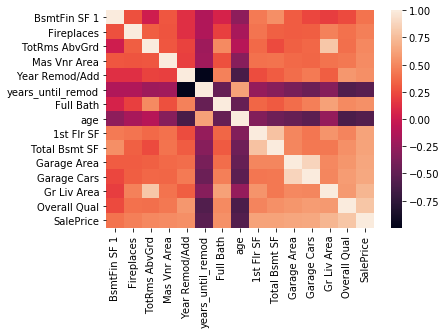

In [110]:
corrmat = train_clean[strong_corrs.index].corr()
sns.heatmap(corrmat);

The following columns are strongly correlated: 
<ul>
<li>Gr Liv Area and TotRms AbvGrd</li>
<li>Garage Area and Garage Cars</li>
<li>Total Bsmt SF and 1st Flr SF </li>
</ul>

I'll keep one for every couple, the one with the strongest correlation, so I'll keep 'Gr Liv Area', 'Garage Cars' and 'Total Bsmt SF' and I'll keep only the most promising numeric columns.

In [111]:
numeric_columns = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Total Bsmt SF", "age",
                   "Full Bath" ,"years_until_remod", "Year Remod/Add", 
                   "Mas Vnr Area", "Fireplaces", "BsmtFin SF 1", "SalePrice"]

In [112]:
train_numeric = train_clean[numeric_columns]

In [113]:
train_numeric.shape[1]

12

In [114]:
test_numeric = test_clean[numeric_columns]

### Scaling numerical features

The columns with numerical features have different range of values in different columns so I'll scale them using the MinMaxScaler from scikit.learn.

In [115]:
from sklearn.preprocessing import MinMaxScaler

In [116]:
scaler = MinMaxScaler()
X_train = train_numeric.drop("SalePrice", axis=1)
X_train.shape

(1459, 11)

In [117]:
X_test = test_numeric.drop("SalePrice", axis=1)
X_test.shape

(1468, 11)

In [118]:
y_train = train_numeric["SalePrice"]
y_test = test_numeric["SalePrice"]

In [119]:
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)

In [120]:
numeric_columns = numeric_columns[0:-1]

In [121]:
X_scaled_train_df = pd.DataFrame(X_scaled_train, 
                                 columns = numeric_columns, index = train_clean.index)

In [122]:
X_scaled_test = scaler.transform(X_test)

In [123]:
X_scaled_test_df = pd.DataFrame(X_scaled_test, columns= numeric_columns, index=test_clean.index)

### Multi-feature Regression with Only Numeric Values

In [124]:
lr = LinearRegression()

In [125]:
lr.fit(X_scaled_train_df, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [126]:
predictions = lr.predict(X_scaled_test_df)

In [127]:
multi_num_rmse = np.sqrt(mean_squared_error(y_test, predictions))
multi_num_rmse

32050.698123480688

In [128]:
(56000 - 32000)/56000

0.42857142857142855

In [129]:
(68000 - 32000)/68000

0.5294117647058824

Using 11 numerical features the rmse for the model is about 32,000 dollars, we increased the accuracy of  percentage ranging from 43% to 53% respect to a simple linear regression model with just one feature, which ranged from 56,000 to 68,000 dollars.

### Selecting Categorical Features

In [130]:
category_train = train_clean.select_dtypes(include=['category']).copy()

In [131]:
category_test = test_clean.select_dtypes(include=['category']).copy()

In [132]:
numeric_train_df = X_scaled_train_df.copy()

In [133]:
def combine_category(df_numeric, category, is_test=False):
    if is_test:
        column = test_clean[category]
    else:
        column = train_clean[category]
    dummies = pd.get_dummies(column, prefix= category[0:10])
    concat_df = pd.concat([df_numeric, dummies], axis=1).reset_index(drop=True)
    return concat_df

In [134]:
def train_and_test_category_with_numeric(category, X_train, X_test, y_train, y_test):
    train_df_comb = combine_category(X_train, category)
    test_df_comb =  combine_category(X_test, category, is_test=True)
    lr = LinearRegression()
    lr.fit(train_df_comb, y_train)
    prediction = lr.predict(test_df_comb)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    return rmse

In [135]:
category_rmse ={}
for col in category_train.columns:
    rmse = train_and_test_category_with_numeric(col, X_scaled_train_df, X_scaled_test_df, y_train, y_test)
    category_rmse[col] = rmse

In [136]:
rmse_vals = pd.Series(category_rmse)

In [137]:
rmse_vals.sort_values()

Bsmt Qual         30174.259038
Neighborhood      30414.664842
Kitchen Qual      30656.126596
Exter Qual        30803.177301
Bsmt Exposure     31135.181769
Foundation        31141.885461
MS Zoning         31308.264710
Exterior 1st      31501.995320
Heating QC        31556.254146
Land Contour      31557.744066
Exterior 2nd      31629.100808
BsmtFin Type 1    31747.075309
Bldg Type         31820.316074
Land Slope        31825.133103
Lot Config        31849.008903
Functional        31855.219710
Bsmt Cond         31881.279233
BsmtFin Type 2    31890.976420
Heating           31961.607716
Condition 1       31968.870955
Roof Style        31986.159150
House Style       32006.782984
Exter Cond        32019.898861
MS SubClass       32050.698123
Utilities         32058.226370
Street            32062.017429
Electrical        32162.770663
Central Air       32180.261200
Condition 2       32323.793159
Mas Vnr Type      32535.959863
Paved Drive       32541.646697
Roof Matl         32781.558412
Lot Shap

I'll select only the features that increase the value of the rmse.

In [138]:
rmse_sorted = (rmse_vals[rmse_vals < multi_num_rmse]).sort_values()
rmse_sorted

Bsmt Qual         30174.259038
Neighborhood      30414.664842
Kitchen Qual      30656.126596
Exter Qual        30803.177301
Bsmt Exposure     31135.181769
Foundation        31141.885461
MS Zoning         31308.264710
Exterior 1st      31501.995320
Heating QC        31556.254146
Land Contour      31557.744066
Exterior 2nd      31629.100808
BsmtFin Type 1    31747.075309
Bldg Type         31820.316074
Land Slope        31825.133103
Lot Config        31849.008903
Functional        31855.219710
Bsmt Cond         31881.279233
BsmtFin Type 2    31890.976420
Heating           31961.607716
Condition 1       31968.870955
Roof Style        31986.159150
House Style       32006.782984
Exter Cond        32019.898861
dtype: float64

In [139]:
best_rmse = rmse_sorted.iloc[0:8]

In [140]:
best_rmse.index

Index(['Bsmt Qual', 'Neighborhood', 'Kitchen Qual', 'Exter Qual',
       'Bsmt Exposure', 'Foundation', 'MS Zoning', 'Exterior 1st'],
      dtype='object')

In [141]:
best_rmse_cols = list(best_rmse.index)

In [142]:
rmse_features = {}
for i in range(2,len(best_rmse_cols) +1):
    features = best_rmse_cols[0:i]
    dummies_train = pd.get_dummies(train_clean[features])
    dummies_test = pd.get_dummies(test_clean[features])
    train_feat = pd.concat([X_scaled_train_df, dummies_train], axis=1).reset_index(drop=True)
    test_feat = pd.concat([X_scaled_test_df, dummies_test], axis=1).reset_index(drop=True)
    lr= LinearRegression()
    lr.fit(train_feat, train_clean["SalePrice"])
    prediction = lr.predict(test_feat)
    rmse = np.sqrt(mean_squared_error(test_clean["SalePrice"],prediction))
    key = "11 numeric and {} category features rmse".format(i)
    rmse_features[key] = rmse

In [143]:
rmse_features

{'11 numeric and 2 category features rmse': 28705.13917635209,
 '11 numeric and 3 category features rmse': 28062.54629618169,
 '11 numeric and 4 category features rmse': 27854.569800381145,
 '11 numeric and 5 category features rmse': 27410.785257781816,
 '11 numeric and 6 category features rmse': 26952.757287151697,
 '11 numeric and 7 category features rmse': 26971.09027212846,
 '11 numeric and 8 category features rmse': 26875.61844711392}

The best result is for 6 category features, listed below:

In [144]:
for i in best_rmse[0:6].index:
    print(i)

Bsmt Qual
Neighborhood
Kitchen Qual
Exter Qual
Bsmt Exposure
Foundation


### Training and Testint with Cross Validation

Below I'll train and test the model with the features selected above, so the 11 numeric feature columns and six category columns.

In [145]:
category_list =list(best_rmse[0:6].index)
category_list

['Bsmt Qual',
 'Neighborhood',
 'Kitchen Qual',
 'Exter Qual',
 'Bsmt Exposure',
 'Foundation']

In [146]:
numeric_list = list(X_scaled_train_df.select_dtypes(include=[np.number]).columns)
numeric_list

['Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 'Total Bsmt SF',
 'age',
 'Full Bath',
 'years_until_remod',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Fireplaces',
 'BsmtFin SF 1']

In [147]:
all_columns = category_list
all_columns.extend(numeric_list)
all_columns.append("SalePrice")
all_columns

['Bsmt Qual',
 'Neighborhood',
 'Kitchen Qual',
 'Exter Qual',
 'Bsmt Exposure',
 'Foundation',
 'Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 'Total Bsmt SF',
 'age',
 'Full Bath',
 'years_until_remod',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Fireplaces',
 'BsmtFin SF 1',
 'SalePrice']

In [148]:
def select_features(df, all_columns, threshold):
    """
    
     Select the features in all_columns
     Create the columns age (age of the house) and years_until_remod (years since the
     last renovation)
     Group category values with less than 25 elements to "other".
     Impute object or category columns with the most frequent values
     Tranform all the object columns to category.
     
     Parameters:
     df (DataFrame): the uncleaned DataFrame
     all_columns (List): the features selected for the model
     threshold(float or int): the limit for the max percentage of null values in columns
     
     Returns:
     the transformed and cleaned df (DataFrame)
     
    """
    df["age"] = df["Yr Sold"] - df["Year Built"]
    df.drop(df["age"][df["age"] < 0].index, axis = 0, inplace=True)
    df["years_until_remod"] = df["Yr Sold"] - df["Year Built"]
    df = df[all_columns]
    df_category = df.select_dtypes(include=["object", "category"])
    for col in list(df_category.columns):
        #print(df_category.columns)
        counts = df[col].value_counts()
        most_frequent = counts.sort_values(ascending=False).index[0]
        df[col].fillna(most_frequent, inplace=True)
        for index, value in counts.iteritems():
            if value <= threshold:
                df[col][df[col] == index] = 'other'
        df[col] = df[col].astype('category')    
    return df

In [149]:
def transform_features_train(df_train):
    """
      Transform the train DataFrame.
      Impute numeric columns with the mean of the column.
      Scale the numeric values with a MinMaxScaler.
      Create dummy columns for category columns.
      
      Parameters:
      df_train (DataFrame): the train DataFrame to transform
      
      Returns:
        the transformed DataFrame suitable for machine learning.
    """
    df_numeric = df_train.select_dtypes(include=[np.number])
    for col in df_numeric.columns:
        df_numeric[col].fillna(df_train[col].mean(), inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(df_numeric)
    numeric_transform = scaler.transform(df_numeric)
    numeric_transform_df = pd.DataFrame(numeric_transform, columns = df_numeric.columns, index= df_numeric.index)
    df_category = df_train.select_dtypes(include=['category'])
    category_cols = list(df_category.columns)
    df_dummies = pd.get_dummies(df_train[category_cols])
    concat_df = pd.concat([numeric_transform_df, df_dummies], axis=1).reset_index(drop=True)
    return concat_df

In [150]:
def transform_features_test(df_test, df_train, category_columns):
    """
       Transform the test DataFrame.
       Impute numeric columns with the mean of the same train column.
       Scale numeric columms with a MinMaxScaler.
       Create dummies from category columns
       
       Parameters:
       df_test (DataFrame): the test DataFrame
       df_train (DataFrame): the cleaned train DataFrame
       category_columns(List): the list of category columns for the model
       
       Returns:
       The test transformed DataFrame suitable for machine learning.
        
    """
    df_numeric = df_test.select_dtypes(include=[np.number])
    for col in df_numeric.columns:
        df_numeric[col].fillna(df_train[col].mean(), inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(df_numeric)
    numeric_transform = scaler.transform(df_numeric)
    numeric_transform_df = pd.DataFrame(numeric_transform, columns = df_numeric.columns, index= df_numeric.index)
    df_category = df_test.select_dtypes(include=['category'])
    category_cols = list(df_category.columns)
    df_dummies = pd.get_dummies(df_test[category_cols])
    concat_df = pd.concat([numeric_transform_df, df_dummies], axis=1).reset_index(drop=True)
    return concat_df

In [151]:
def transform_and_train(train_df, test_df, categories, y_train, y_test):
    """
       Clean train and test the datasets and performs LinearRegression
       
       Parameters:
       train_df (DataFrame): the training dataset
       test_df (DataFrame): the testing dataset
       categories (List): the list of category columns of the model
       y_train (Series): the training target column for the Linear Regression
       y_test (Series): the testing target column.
       
       Returns:
       rmse (float): the Root Mean Squared Error for the Linear Regression performed
       on the training set and tested on the test set.
    """
    train_clean = transform_features_train(train_df)
    test_clean = transform_features_test(test_df, train_clean, categories)
    lr = LinearRegression()
    lr.fit(train_clean, y_train )
    prediction = lr.predict(test_clean)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    return rmse

In [152]:
from sklearn.model_selection import KFold
np.random.seed(1)
def cross_validation(df,category_cols, k=0):
    """
     Performs cross validation for different values of k.
     k = 0, holdout validation
     k= 1, simple cross validation
     k > 1 K-fold validation with scikit-learn KFold class.
    """
    
    if k < 0:
        raise ValueError("k must be zero or positive")
        
    if k == 0:   
        
        train = df[:1460]
        test = df[1460:]
        y_train = train["SalePrice"]
        y_test = test["SalePrice"]
        rmse = transform_and_train(train, test,category_list, y_train, y_test)
        return rmse
    
    elif k == 1:
        df = df.sample(frac= 1)
        rmses = []
        fold_1 = df[:1460]
        fold_2 = df[1460:]
        y_fold_1 = fold_1["SalePrice"]
        y_fold_2 = fold_2["SalePrice"]
        rmse_1 = transform_and_train(fold_1.copy(), fold_2.copy(), category_list, y_fold_1, y_fold_2)
        rmses.append(rmse_1)
        rmse_2 = transform_and_train(fold_2.copy(), fold_1.copy(), category_list, y_fold_2, y_fold_1)
        rmses.append(rmse_2)
        return rmses

    else:
        kf = KFold(n_splits= k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            y_train = train["SalePrice"]
            y_test = test["SalePrice"]
            train_clean = transform_features_train(train)
            test_clean = transform_features_test(test, train_clean, category_list)
            lr = LinearRegression()
            lr.fit(train_clean, y_train)
            prediction = lr.predict(test_clean)
            rmse = np.sqrt(mean_squared_error(y_test, prediction))
            rmse_values.append(rmse)
        return rmse_values
        

In [153]:
houses = pd.read_csv("AmesHousing.tsv", delimiter="\t")

In [154]:
houses_clean = select_features(houses, all_columns, 5)

In [155]:
for fold in [0, 1, 3, 4, 5]:
    print("---------------------------------")
    print("validating for k = {}".format(fold))
    rmse = cross_validation(houses_clean.copy(), category_list, k=fold)
    print("rmse values:")
    print(rmse)
    if fold > 0:
       print("mean : {}".format(np.mean(rmse)))
    print("---------------------------------")

---------------------------------
validating for k = 0
rmse values:
35575.1424962999
---------------------------------
---------------------------------
validating for k = 1
rmse values:
[42731.022341605625, 35122.39860361994]
mean : 38926.71047261279
---------------------------------
---------------------------------
validating for k = 3
rmse values:
[15202.353456257633, 36093.256684344604, 16046.546004494061]
mean : 22447.385381698765
---------------------------------
---------------------------------
validating for k = 4
rmse values:
[41998.49919045644, 31018.654892912105, 53341.27064892245, 39285.53454914323]
mean : 41410.989820358554
---------------------------------
---------------------------------
validating for k = 5
rmse values:
[23961.900536707148, 52887.38908108129, 16344.300062533463, 43833.27460395919, 2842.7862508361445]
mean : 27973.93010702345
---------------------------------


All the trainings with cross validation confirm what we have found: the multi-regression model has a significative increase in accuracy respect to the simple regression model, with an error estimated between about 39,000 for the holdout validation to about 22,000 for the model trained with k-fold validation with k=3, much less than the error ranging from 56,000 to 68,000 of the simple model.